Cell 1: Import and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

# Setup tampilan grafik
sns.set(style="whitegrid")
print("Libraries loaded successfully!")

Libraries loaded successfully!


Cell 2 : Generate Data

In [8]:
def generate_data_notebook(n_samples=1000, anomaly=False):
    data = []
    for _ in range(n_samples):
        complexity = np.random.randint(1, 6) 
        skill = np.random.randint(1, 4)      
        hist_avg = complexity * 2.0          
        
        if not anomaly:
            # Junior Logic Fix
            if skill == 1:
                skill_factor = 1.3; noise = np.random.uniform(0.8, 1.6)
            elif skill == 2:
                skill_factor = 1.0; noise = np.random.uniform(0.8, 1.2)
            else:
                skill_factor = 0.8; noise = np.random.uniform(0.7, 1.1)
            duration = hist_avg * skill_factor * noise
            label = 0
        else:
            markup_factor = np.random.uniform(1.6, 2.5)
            duration = hist_avg * markup_factor
            label = 1
            
        data.append([complexity, hist_avg, skill, duration, label])
    return pd.DataFrame(data, columns=['complexity', 'hist_avg', 'skill', 'duration', 'label'])

# Generate 5000 Data
df_normal = generate_data_notebook(4750, False)
df_anomaly = generate_data_notebook(250, True)
df = pd.concat([df_normal, df_anomaly], ignore_index=True)

# Tambah Feature Ratio
df['deviation_ratio'] = df['duration'] / df['hist_avg']

print(f"Data generated. Total rows: {len(df)}")
df.head()

Data generated. Total rows: 5000


,complexity,hist_avg,skill,duration,label,deviation_ratio
0,3,6.0,2,6.937906,0,1.156318
1,1,2.0,3,1.521975,0,0.760987
2,1,2.0,2,1.842429,0,0.921215
3,2,4.0,1,4.600955,0,1.150239
4,1,2.0,1,2.360051,0,1.180025


Cell 3 : Visualisasi Data (Melihat Sebaran Data)

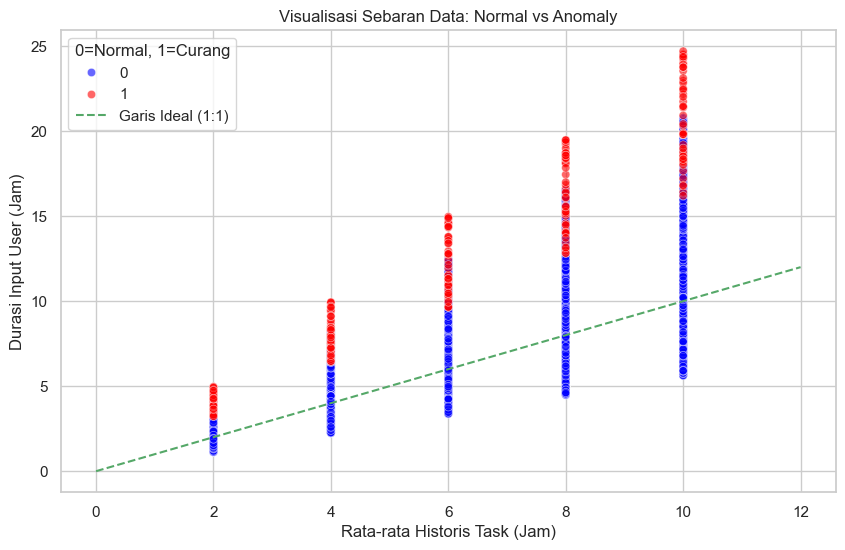

In [9]:
plt.figure(figsize=(10, 6))
# Plot scatter: X=Avg Task, Y=Input Duration, Color=Label
sns.scatterplot(data=df, x='hist_avg', y='duration', hue='label', palette={0: 'blue', 1: 'red'}, alpha=0.6)

plt.title("Visualisasi Sebaran Data: Normal vs Anomaly")
plt.xlabel("Rata-rata Historis Task (Jam)")
plt.ylabel("Durasi Input User (Jam)")
plt.plot([0, 12], [0, 12], 'g--', label="Garis Ideal (1:1)") # Garis referensi
plt.legend(title="0=Normal, 1=Curang")
plt.show()

Cell 4 : Training Model

In [10]:
features = ['complexity', 'hist_avg', 'skill', 'duration', 'deviation_ratio']
X = df[features]
y = df['label']

print("Starting training...")
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)
print("Training done.")

Starting training...
Training done.


Cell 5 : Evaluasi dan Cek Error

Akurasi Model: 97.80%


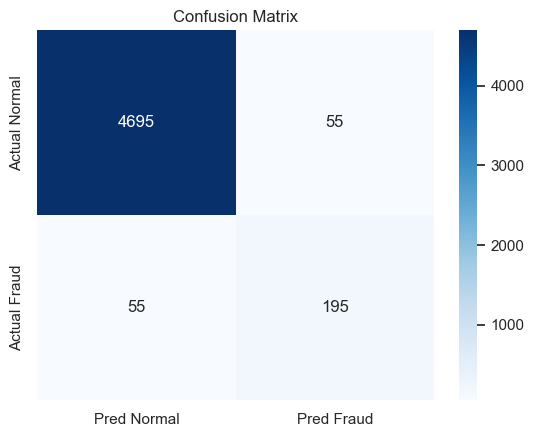

In [11]:
# Prediksi
preds = model.predict(X)

# Convert (-1 jadi 1, 1 jadi 0)
preds_mapped = [1 if x == -1 else 0 for x in preds]

# Hitung Akurasi
acc = accuracy_score(y, preds_mapped)
print(f"Akurasi Model: {acc*100:.2f}%")

# Tampilkan Confusion Matrix (Berapa yang salah tebak)
cm = confusion_matrix(y, preds_mapped)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Normal', 'Pred Fraud'], yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title("Confusion Matrix")
plt.show()

Cell 6 : Test Manual

In [12]:
# === GANTI ANGKA DISINI ===
INPUT_COMPLEXITY = 1  # 1 (Mudah)
INPUT_AVG = 2.0       # Biasanya 2 jam
INPUT_SKILL = 1       # Junior
INPUT_DURATION = 3.5  # Input 3.5 jam (Rasio 1.75x)

# ==========================
def test_model(clf, comp, avg, sk, dur):
    ratio = dur / avg
    input_df = pd.DataFrame([[comp, avg, sk, dur, ratio]], 
                            columns=['complexity', 'hist_avg', 'skill', 'duration', 'deviation_ratio'])
    pred = clf.predict(input_df)[0]
    score = clf.decision_function(input_df)[0]
    
    status = "✅ AMAN" if pred == 1 else "🚨 ANOMALI"
    print(f"Input: {dur} jam (Avg {avg}). Rasio: {ratio:.2f}x")
    print(f"Hasil: {status} (Score: {score:.4f})")

test_model(model, INPUT_COMPLEXITY, INPUT_AVG, INPUT_SKILL, INPUT_DURATION)

Input: 3.5 jam (Avg 2.0). Rasio: 1.75x
Hasil: ✅ AMAN (Score: 0.0274)
